In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
!pip install pyPDF2

In [2]:
!pip install --upgrade tensorflow

In [3]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Lambda, SeparableConv2D, GlobalAvgPool2D, Input, Average, ReLU, Dropout, DepthwiseConv2D, Dense, GlobalAvgPool2D, GlobalAveragePooling2D,Conv2D, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, AvgPool2D, Concatenate, MaxPool2D
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU


from keras.preprocessing import image

from glob import glob

from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential,Model
import pandas as pd
# from keras.applications.resnet import ResNet50

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import time
import datetime
import os
import cv2
import io

# import imutils
import matplotlib.pyplot as plt
from os import listdir

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

2024-03-01 06:27:13.929521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 06:27:13.929575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 06:27:13.931029: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Set the path to the dataset
# dataset_path = "C:/Users/USER/ML/Latest/def_data"
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"

# Define the training and testing directories
train_dir = os.path.join(dataset_path, "/kaggle/input/brain-tumor-mri-dataset/Training")
test_dir = os.path.join(dataset_path, "/kaggle/input/brain-tumor-mri-dataset/Testing")

# Define the categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]

1321
1339
1595
1457


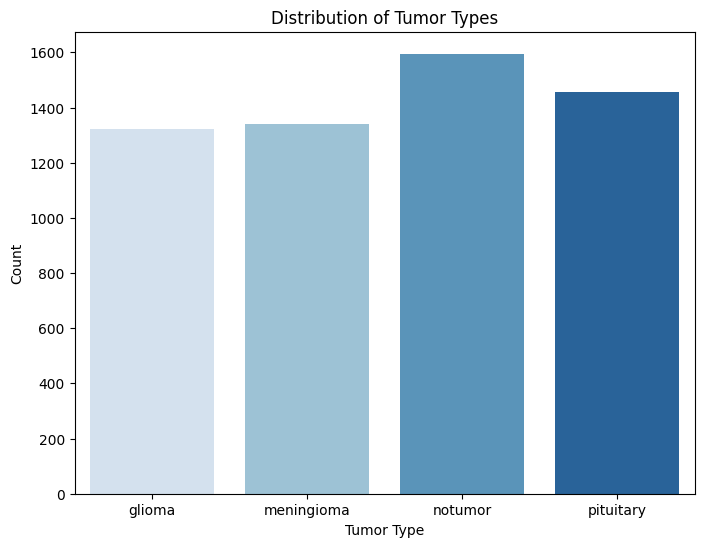

In [5]:
# Load and preprocess the dataset
train_data = []
for category in categories:
    folder_path = os.path.join(train_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    print(count)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

train_df = pd.concat(train_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x="Category", y="Count", palette = "Blues")#######, legend=False
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

300
306
405
300


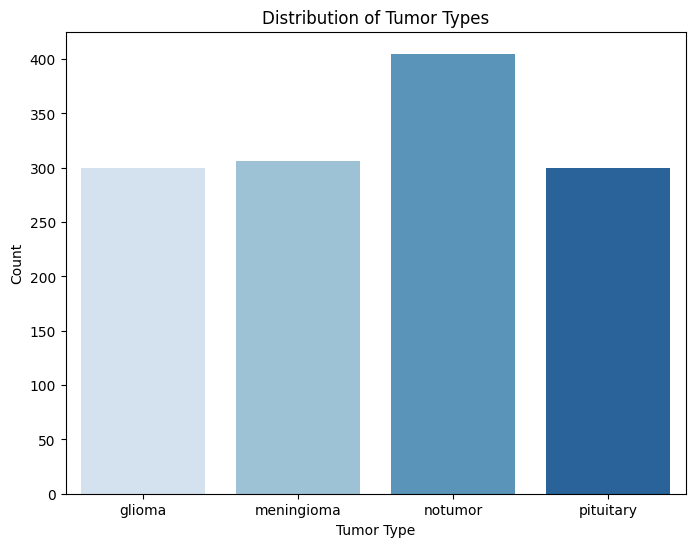

In [6]:
# Load and preprocess the dataset
test_data = []
for category in categories:
    folder_path = os.path.join(test_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    print(count)
    test_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

test_df = pd.concat(test_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=test_df, x="Category", y="Count", palette = "Blues")
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

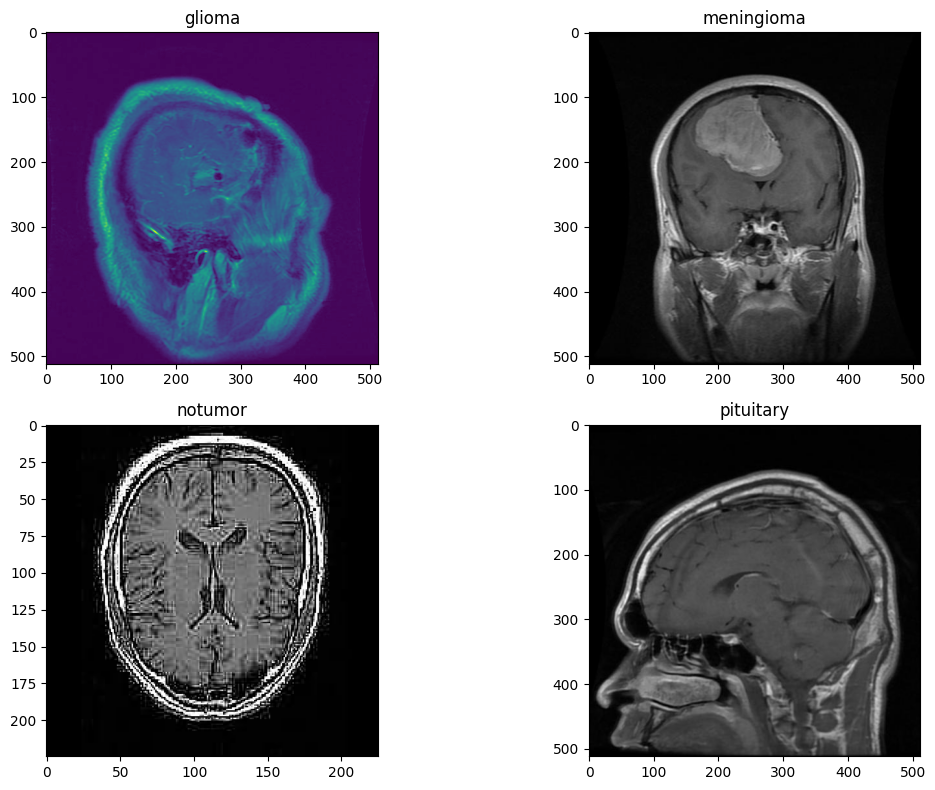

In [7]:
# Visualize sample images for each tumor type
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("on")
plt.tight_layout()
plt.show()

In [8]:
# Set the image size
image_size = (224, 224)

# Set the batch size for training
batch_size = 32

# Set the number of epochs for training
epochs = 100

In [9]:
# Data augmentation and preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [10]:
def xception(input_shape, n_classes):

  def conv_bn(x, f, k, s=1, p='same'):
    x = Conv2D(f, k, strides=s, padding=p, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


  def sep_bn(x, f, k, s=1, p='same'):
    x = SeparableConv2D(f, k, strides=s, padding=p, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


  def entry_flow(x):
    x = conv_bn(x, 32, 3, 2)
    x = ReLU()(x)
    x = conv_bn(x, 64, 3)
    tensor = ReLU()(x)

    x = sep_bn(tensor, 128, 3)
    x = ReLU()(x)
    x = sep_bn(x, 128, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, 128, 1, 2)

    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, 256, 3)
    x = ReLU()(x)
    x = sep_bn(x, 256, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, 256, 1, 2)

    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, 728, 3)
    x = ReLU()(x)
    x = sep_bn(x, 728, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, 728, 1, 2)
    x = Add()([tensor, x])

    return x


  def middle_flow(tensor):
    for _ in range(8):
      x = ReLU()(tensor)
      x = sep_bn(x, 728, 3)
      x = ReLU()(x)
      x = sep_bn(x, 728, 3)
      x = ReLU()(x)
      x = sep_bn(x, 728, 3)

      tensor = Add()([tensor, x])

    return tensor


  def exit_flow(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, 728, 3)
    x = ReLU()(x)
    x = sep_bn(x, 1024, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, 1024, 1, 2)

    x = Add()([tensor, x])
    x = sep_bn(x, 1536, 3)
    x = ReLU()(x)
    x = sep_bn(x, 2048, 3)
    x = ReLU()(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(n_classes, activation='softmax')(x)

    return x


  input = Input(input_shape)

  x = entry_flow(input)
  x = middle_flow(x)
  output = exit_flow(x)

  model = Model(input, output)

  return model

In [11]:
IMG_SHAPE = (224, 224, 3)

In [12]:
xception_model = xception(IMG_SHAPE, 4)

In [13]:
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 112, 112, 32)         0         ['batch_normalization[0][0

In [14]:
from keras.applications.inception_v3 import InceptionV3
InceptionV3 = InceptionV3(input_shape=(224, 224, 3),
            weights='imagenet',
            include_top=False)

In [15]:
for layer in InceptionV3.layers:
    layer.trainable = False

In [16]:
folders = glob('/kaggle/input/brain-tumor-mri-dataset/Training/*')
print(len(folders))

4


In [17]:
x = InceptionV3.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)
InceptionV3_model = Model(inputs=InceptionV3.input, outputs=prediction)

In [18]:
InceptionV3_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_40 (Ba  (None, 111, 111, 32)         96        ['conv2d_6[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization_40

In [19]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='Ensemble_kaggke_Xception_InceptionV3.h5',
                             mode='max',
                             verbose=2,
                             save_best_only=True)
callbacks = [checkpoint]
start = datetime.now()

In [20]:
xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# adam = keras.optimizers.Adam(learning_rate=0.001)
InceptionV3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# Train the model
history_xception_model = xception_model.fit(
    train_set,
    steps_per_epoch=train_set.samples // batch_size,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=test_set.samples // batch_size
)

Epoch 1/100


I0000 00:00:1709274463.460793    1012 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


178/178 [==============================] - 131s 546ms/step - loss: 0.8233 - accuracy: 0.6680 - val_loss: 1.4254 - val_accuracy: 0.2102
Epoch 2/100
178/178 [==============================] - 90s 506ms/step - loss: 0.6130 - accuracy: 0.7660 - val_loss: 2.3162 - val_accuracy: 0.2102
Epoch 3/100
178/178 [==============================] - 91s 508ms/step - loss: 0.4865 - accuracy: 0.8197 - val_loss: 1.5172 - val_accuracy: 0.4945
Epoch 4/100
178/178 [==============================] - 91s 507ms/step - loss: 0.3986 - accuracy: 0.8558 - val_loss: 18.5167 - val_accuracy: 0.4313
Epoch 5/100
178/178 [==============================] - 91s 507ms/step - loss: 0.3084 - accuracy: 0.8907 - val_loss: 26.8235 - val_accuracy: 0.4305
Epoch 6/100
178/178 [==============================] - 91s 507ms/step - loss: 0.2590 - accuracy: 0.9088 - val_loss: 1.8877 - val_accuracy: 0.5859
Epoch 7/100
178/178 [==============================] - 91s 507ms/step - loss: 0.2431 - accuracy: 0.9173 - val_loss: 0.5893 - val_accu

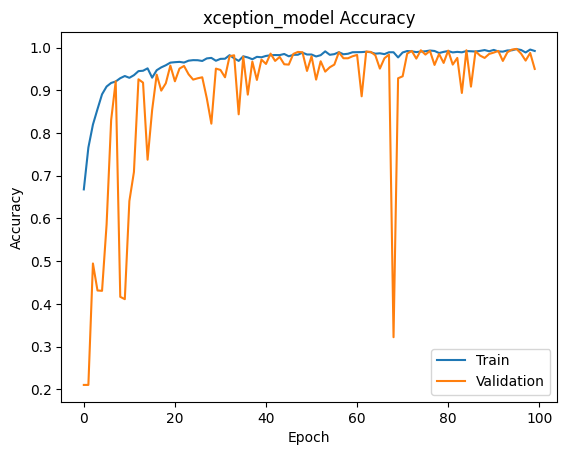

In [23]:
# Plot the training and validation accuracy over epochs
plt.plot(history_xception_model.history['accuracy'])
plt.plot(history_xception_model.history['val_accuracy'])
plt.title('xception_model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

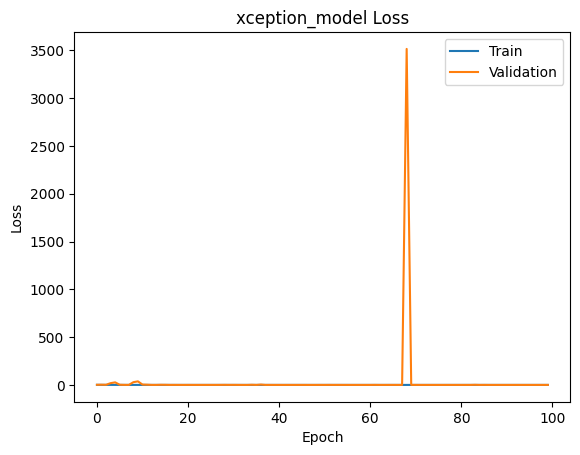

In [24]:
# Plot the training and validation loss over epochs
plt.plot(history_xception_model.history['loss'])
plt.plot(history_xception_model.history['val_loss'])
plt.title('xception_model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [25]:
# Evaluate the model
loss_xception_model, accuracy_xception_model = xception_model.evaluate(test_set, steps=test_set.samples // batch_size)
# loss, accuracy = model.evaluate(test_set, steps=32)

print("xception_model Test Loss:", loss_xception_model)
print("xception_model Test Accuracy:", accuracy_xception_model)

40/40 [==============================] - 5s 125ms/step - loss: 0.1886 - accuracy: 0.9500
xception_model Test Loss: 0.18862023949623108
xception_model Test Accuracy: 0.949999988079071


41/41 [==============================] - 9s 200ms/step
[0 0 0 ... 3 3 3]


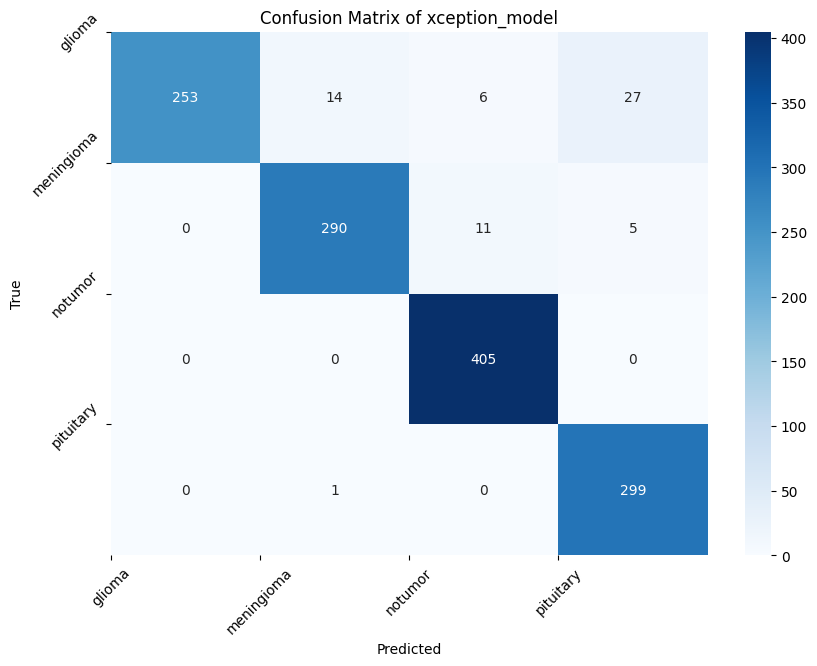

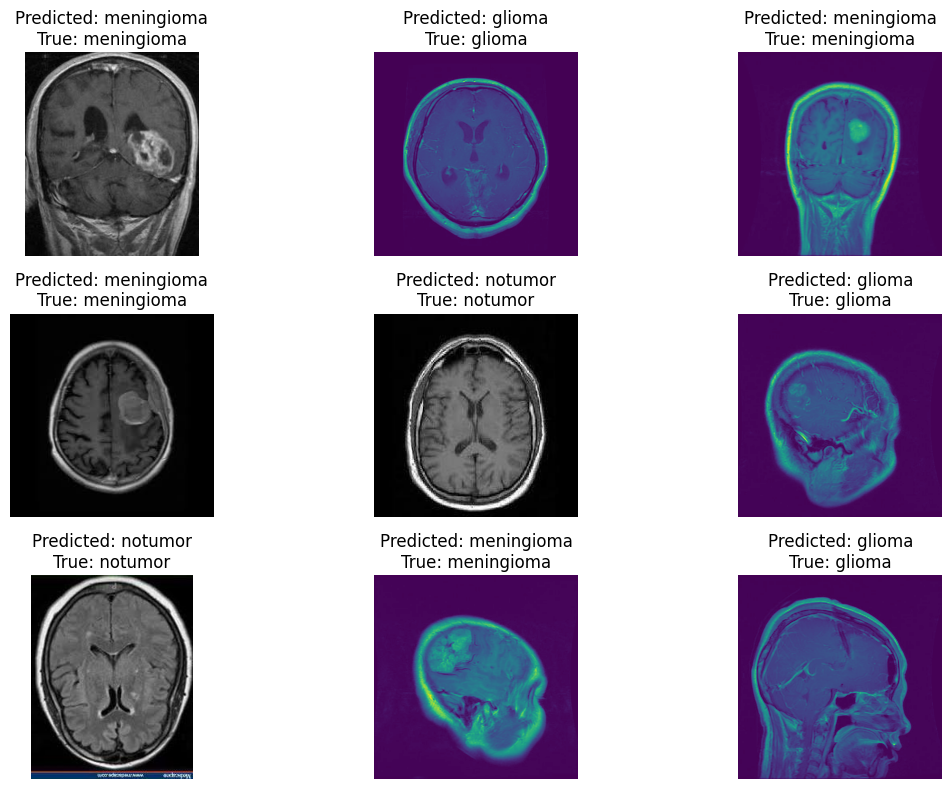

In [26]:
# Make predictions on the test dataset
predictions_xception_model = xception_model.predict(test_set)
predicted_categories_xception_model = np.argmax(predictions_xception_model, axis=1)

true_categories_xception_model = test_set.classes
print(true_categories_xception_model)

# Create a confusion matrix
confusion_matrix_xception_model = tf.math.confusion_matrix(true_categories_xception_model, predicted_categories_xception_model)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_xception_model, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of xception_model")
plt.tight_layout() #########
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_set.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
# print(sample_indices)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions_xception_model = [categories[predicted_categories_xception_model[i]] for i in sample_indices]
sample_true_labels_xception_model = [categories[true_categories_xception_model[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions_xception_model[i]}\nTrue: {sample_true_labels_xception_model[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Class: glioma
Precision: 1.0
Recall: 0.8433333333333334
F1-Score: 0.9150090415913201

Class: meningioma
Precision: 0.9508196721311475
Recall: 0.9477124183006536
F1-Score: 0.9492635024549918

Class: notumor
Precision: 0.9597156398104265
Recall: 1.0
F1-Score: 0.9794437726723095

Class: pituitary
Precision: 0.9033232628398792
Recall: 0.9966666666666667
F1-Score: 0.94770206022187



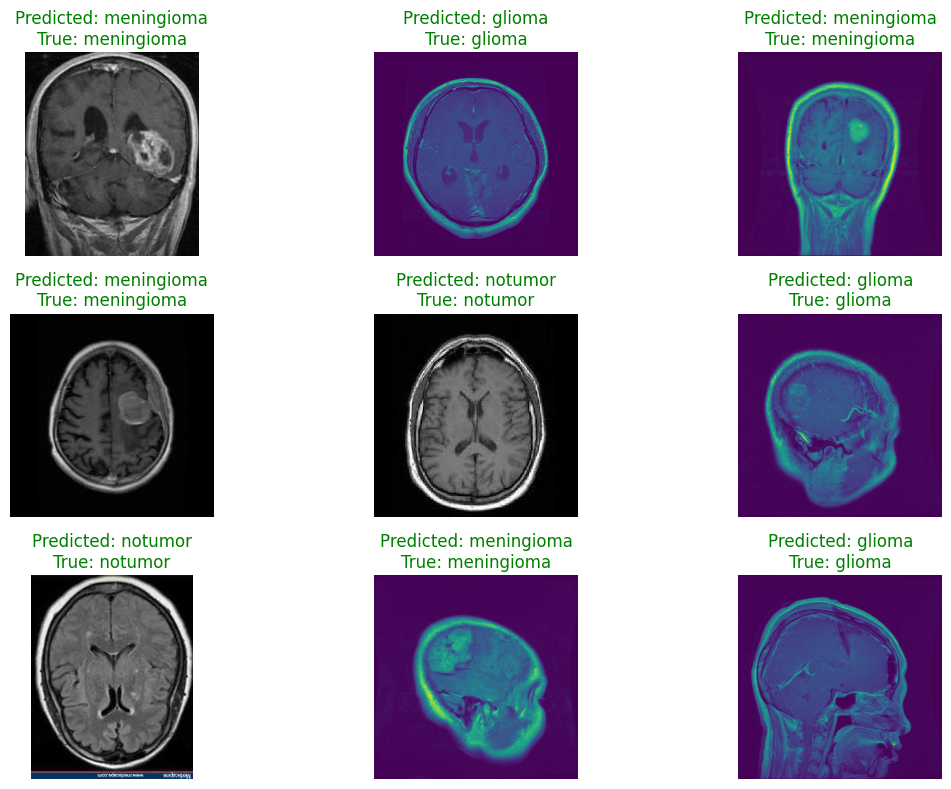

In [27]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision_xception_model = np.diag(confusion_matrix_xception_model) / np.sum(confusion_matrix_xception_model, axis=0)
recall_xception_model = np.diag(confusion_matrix_xception_model) / np.sum(confusion_matrix_xception_model, axis=1)
f1_score_xception_model = 2 * (precision_xception_model * recall_xception_model) / (precision_xception_model + recall_xception_model)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision_xception_model[i]}")
    print(f"Recall: {recall_xception_model[i]}")
    print(f"F1-Score: {f1_score_xception_model[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions_xception_model[i] == sample_true_labels_xception_model[i]:
        plt.title(f"Predicted: {sample_predictions_xception_model[i]}\nTrue: {sample_true_labels_xception_model[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions_xception_model[i]}\nTrue: {sample_true_labels_xception_model[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

4


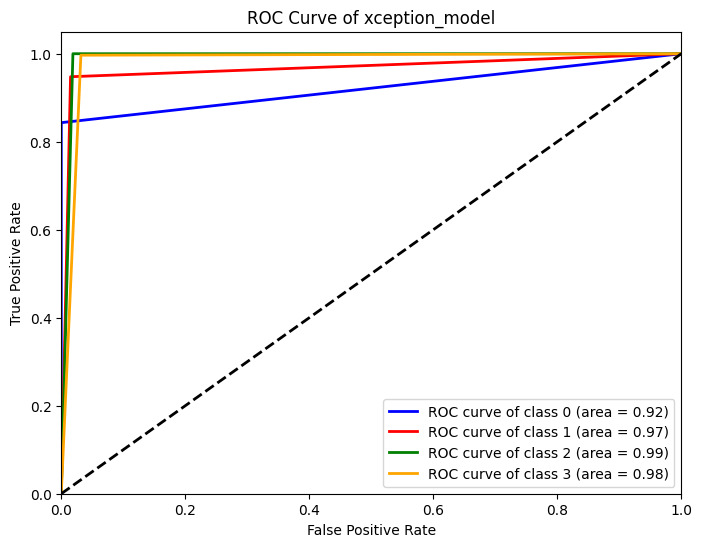

In [28]:
from sklearn.metrics import roc_curve, auc
from keras.models import load_model
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes = glob('/kaggle/input/brain-tumor-mri-dataset/Training/*')
num_classes = len(classes)
print(num_classes)

Y_test_bin = label_binarize(true_categories_xception_model, classes=np.arange(4))
Y_pred_bin = label_binarize(predicted_categories_xception_model, classes=np.arange(4))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']  # Add more colors if you have more classes

class_names = ["glioma", "meningioma", "notumor", "pituitary"]

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of xception_model')
plt.legend(loc="lower right")

plt.show()


In [29]:
# Save the trained model
xception_model.save("Xception_model_brain_tumor_detection_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
# history = model.fit_generator(
history_InceptionV3_model = InceptionV3_model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    steps_per_epoch=train_set.samples // batch_size,
    validation_steps=test_set.samples // batch_size,
#     callbacks=callbacks,
#     verbose=2
)
# duration = datetime.now() - start
# print("Training completed in time: ", duration)

Epoch 1/100
178/178 [==============================] - 93s 477ms/step - loss: 0.7460 - accuracy: 0.7488 - val_loss: 0.6476 - val_accuracy: 0.7469
Epoch 2/100
178/178 [==============================] - 81s 454ms/step - loss: 0.4401 - accuracy: 0.8370 - val_loss: 0.4691 - val_accuracy: 0.8195
Epoch 3/100
178/178 [==============================] - 81s 457ms/step - loss: 0.3901 - accuracy: 0.8516 - val_loss: 0.5234 - val_accuracy: 0.7969
Epoch 4/100
178/178 [==============================] - 82s 459ms/step - loss: 0.3608 - accuracy: 0.8674 - val_loss: 0.3591 - val_accuracy: 0.8516
Epoch 5/100
178/178 [==============================] - 82s 459ms/step - loss: 0.3291 - accuracy: 0.8787 - val_loss: 0.4099 - val_accuracy: 0.8414
Epoch 6/100
178/178 [==============================] - 82s 459ms/step - loss: 0.3171 - accuracy: 0.8771 - val_loss: 0.3328 - val_accuracy: 0.8695
Epoch 7/100
178/178 [==============================] - 81s 456ms/step - loss: 0.3092 - accuracy: 0.8842 - val_loss: 0.2982 -

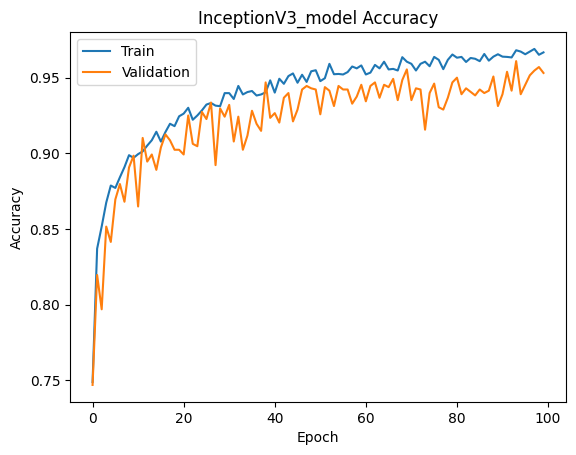

In [31]:
# Plot the training and validation accuracy over epochs
plt.plot(history_InceptionV3_model.history['accuracy'])
plt.plot(history_InceptionV3_model.history['val_accuracy'])
plt.title('InceptionV3_model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

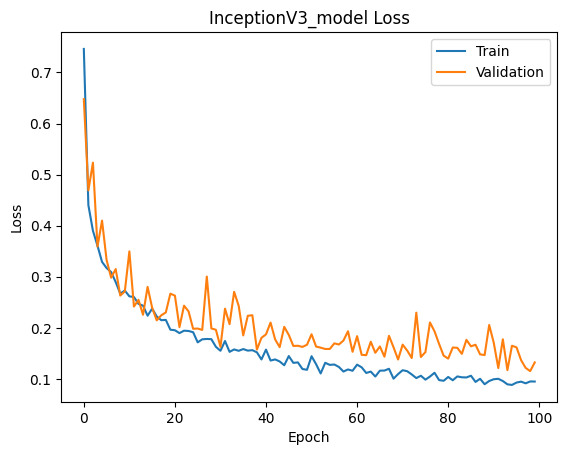

In [32]:
# Plot the training and validation loss over epochs
plt.plot(history_InceptionV3_model.history['loss'])
plt.plot(history_InceptionV3_model.history['val_loss'])
plt.title('InceptionV3_model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [33]:
# Evaluate the model
loss_InceptionV3_model, accuracy_InceptionV3_model = InceptionV3_model.evaluate(test_set, steps=test_set.samples // batch_size)
# loss, accuracy = model.evaluate(test_set, steps=32)

print("InceptionV3_model Test Loss:", loss_InceptionV3_model)
print("InceptionV3_model Test Accuracy:", accuracy_InceptionV3_model)

40/40 [==============================] - 4s 95ms/step - loss: 0.1323 - accuracy: 0.9531
InceptionV3_model Test Loss: 0.132292240858078
InceptionV3_model Test Accuracy: 0.953125


41/41 [==============================] - 8s 176ms/step
[0 0 0 ... 3 3 3]


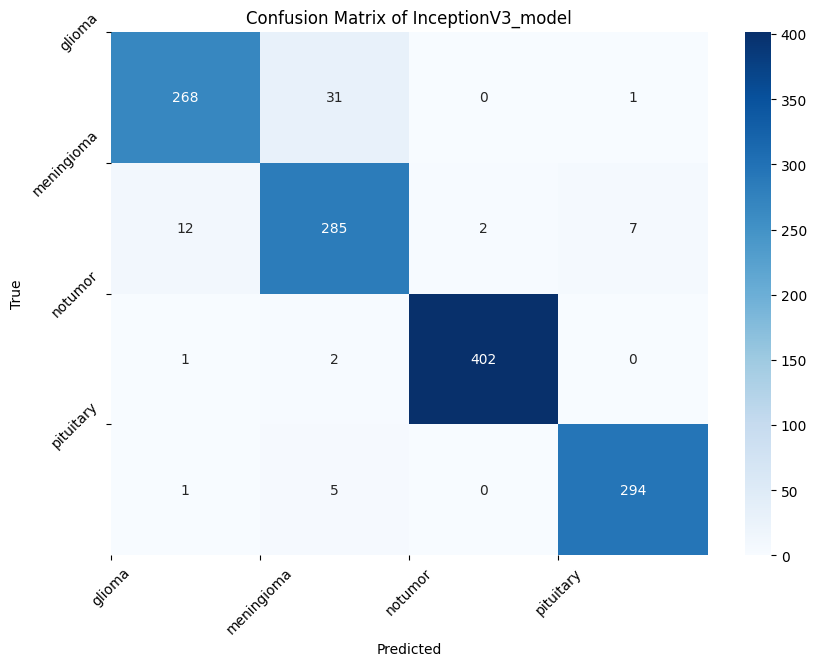

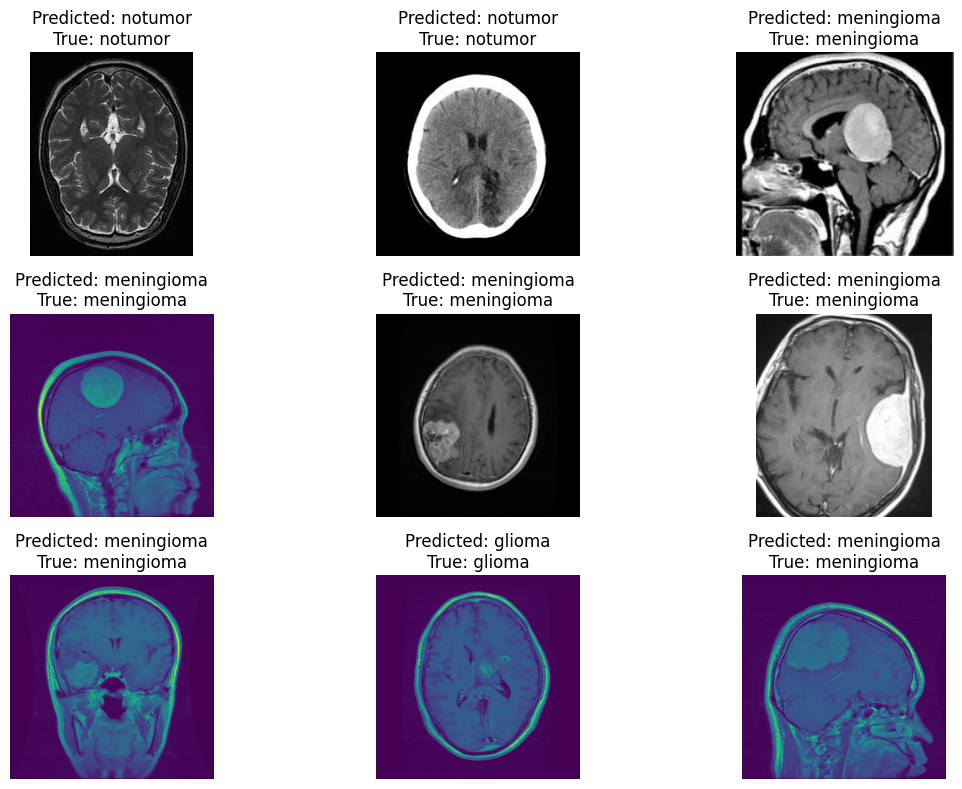

In [34]:
# Make predictions on the test dataset
predictions_InceptionV3_model = InceptionV3_model.predict(test_set)
predicted_categories_InceptionV3_model = np.argmax(predictions_InceptionV3_model, axis=1)

true_categories_InceptionV3_model = test_set.classes
print(true_categories_InceptionV3_model)

# Create a confusion matrix
confusion_matrix_InceptionV3_model = tf.math.confusion_matrix(true_categories_InceptionV3_model, predicted_categories_InceptionV3_model)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_InceptionV3_model, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of InceptionV3_model")
plt.tight_layout() #########
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_set.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
# print(sample_indices)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions_InceptionV3_model = [categories[predicted_categories_InceptionV3_model[i]] for i in sample_indices]
sample_true_labels_InceptionV3_model = [categories[true_categories_InceptionV3_model[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions_InceptionV3_model[i]}\nTrue: {sample_true_labels_InceptionV3_model[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Class: glioma
Precision: 0.950354609929078
Recall: 0.8933333333333333
F1-Score: 0.9209621993127147

Class: meningioma
Precision: 0.8823529411764706
Recall: 0.9313725490196079
F1-Score: 0.9062003179650239

Class: notumor
Precision: 0.995049504950495
Recall: 0.9925925925925926
F1-Score: 0.9938195302843017

Class: pituitary
Precision: 0.9735099337748344
Recall: 0.98
F1-Score: 0.9767441860465117



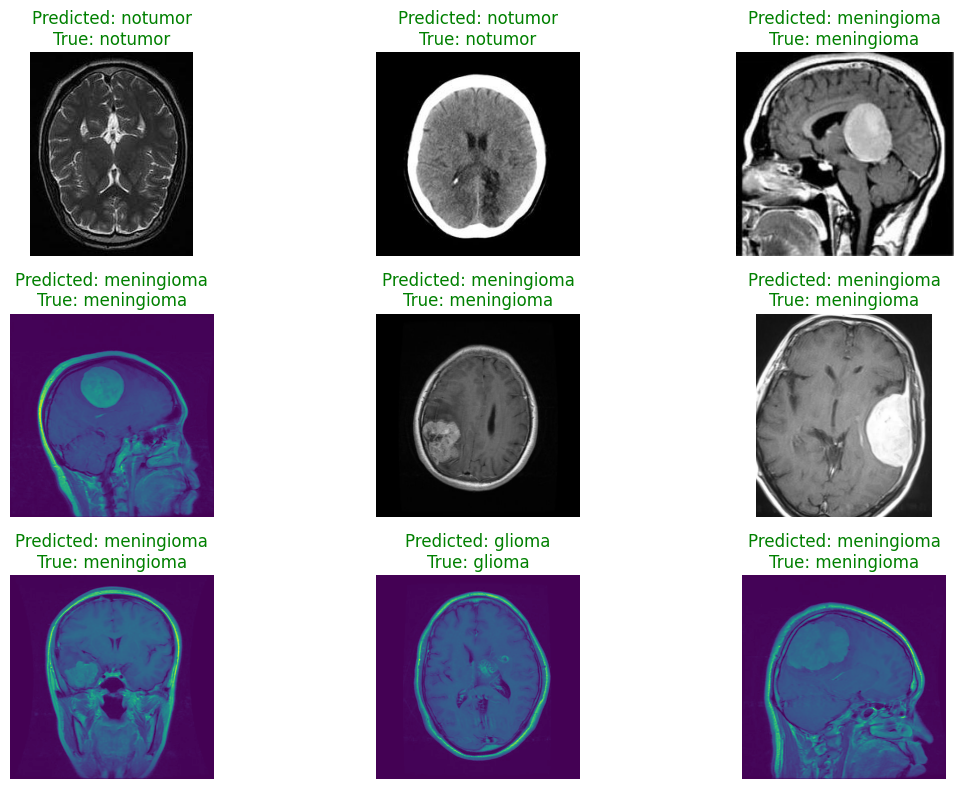

In [35]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision_InceptionV3_model = np.diag(confusion_matrix_InceptionV3_model) / np.sum(confusion_matrix_InceptionV3_model, axis=0)
recall_InceptionV3_model = np.diag(confusion_matrix_InceptionV3_model) / np.sum(confusion_matrix_InceptionV3_model, axis=1)
f1_score_InceptionV3_model = 2 * (precision_InceptionV3_model * recall_InceptionV3_model) / (precision_InceptionV3_model + recall_InceptionV3_model)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision_InceptionV3_model[i]}")
    print(f"Recall: {recall_InceptionV3_model[i]}")
    print(f"F1-Score: {f1_score_InceptionV3_model[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions_InceptionV3_model[i] == sample_true_labels_InceptionV3_model[i]:
        plt.title(f"Predicted: {sample_predictions_InceptionV3_model[i]}\nTrue: {sample_true_labels_InceptionV3_model[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions_InceptionV3_model[i]}\nTrue: {sample_true_labels_InceptionV3_model[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

4


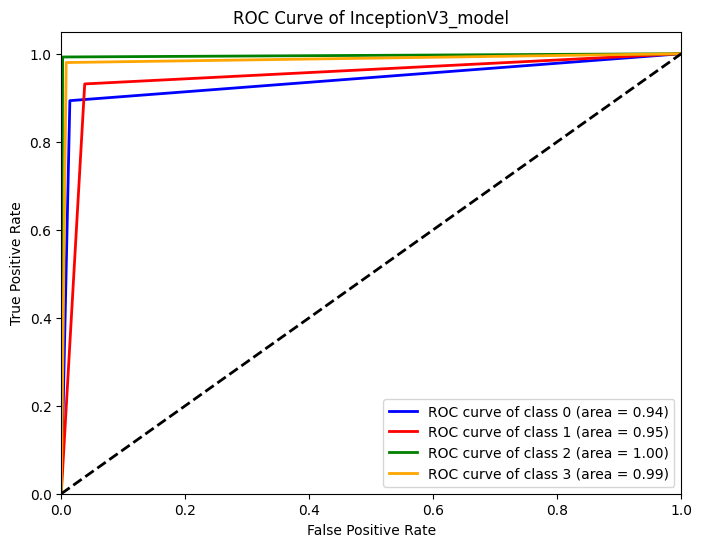

In [36]:
from sklearn.metrics import roc_curve, auc
from keras.models import load_model
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes = glob('/kaggle/input/brain-tumor-mri-dataset/Training/*')
num_classes = len(classes)
print(num_classes)

Y_test_bin = label_binarize(true_categories_InceptionV3_model, classes=np.arange(4))
Y_pred_bin = label_binarize(predicted_categories_InceptionV3_model, classes=np.arange(4))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']  # Add more colors if you have more classes

class_names = ["glioma", "meningioma", "notumor", "pituitary"]

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of InceptionV3_model')
plt.legend(loc="lower right")

plt.show()


In [37]:
# Save the trained model
InceptionV3_model.save("InceptionV3_model_brain_tumor_detection_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
DenseNet201 = keras.applications.DenseNet201(input_shape=(224, 224, 3),
            weights='imagenet',
            include_top=False)

74836368/74836368 [==============================] - 0s 0us/step


In [39]:
for layer in DenseNet201.layers:
    layer.trainable = False

In [40]:
folders = glob('/kaggle/input/brain-tumor-mri-dataset/Training/*')
print(len(folders))

4


In [41]:
x = DenseNet201.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)
DenseNet201_model = Model(inputs=DenseNet201.input, outputs=prediction)

In [42]:
DenseNet201_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_3[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [43]:
DenseNet201_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
# Train the model
history_DenseNet201_model = DenseNet201_model.fit(
    train_set,
    steps_per_epoch=train_set.samples // batch_size,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=test_set.samples // batch_size
)

Epoch 1/100
178/178 [==============================] - 112s 524ms/step - loss: 0.5367 - accuracy: 0.8127 - val_loss: 0.3958 - val_accuracy: 0.8578
Epoch 2/100
178/178 [==============================] - 86s 482ms/step - loss: 0.3084 - accuracy: 0.8852 - val_loss: 0.4439 - val_accuracy: 0.8391
Epoch 3/100
178/178 [==============================] - 87s 486ms/step - loss: 0.2683 - accuracy: 0.9032 - val_loss: 0.3041 - val_accuracy: 0.8898
Epoch 4/100
178/178 [==============================] - 86s 481ms/step - loss: 0.2352 - accuracy: 0.9137 - val_loss: 0.3123 - val_accuracy: 0.8742
Epoch 5/100
178/178 [==============================] - 88s 494ms/step - loss: 0.1992 - accuracy: 0.9255 - val_loss: 0.4055 - val_accuracy: 0.8531
Epoch 6/100
178/178 [==============================] - 87s 485ms/step - loss: 0.2196 - accuracy: 0.9165 - val_loss: 0.2469 - val_accuracy: 0.9031
Epoch 7/100
178/178 [==============================] - 86s 484ms/step - loss: 0.1799 - accuracy: 0.9322 - val_loss: 0.2413 

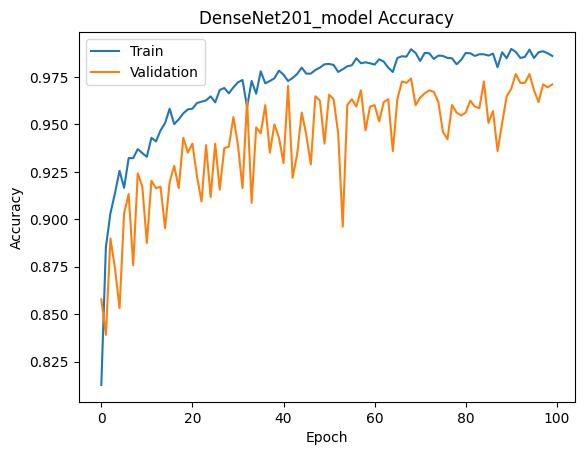

In [45]:
# Plot the training and validation accuracy over epochs
plt.plot(history_DenseNet201_model.history['accuracy'])
plt.plot(history_DenseNet201_model.history['val_accuracy'])
plt.title('DenseNet201_model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

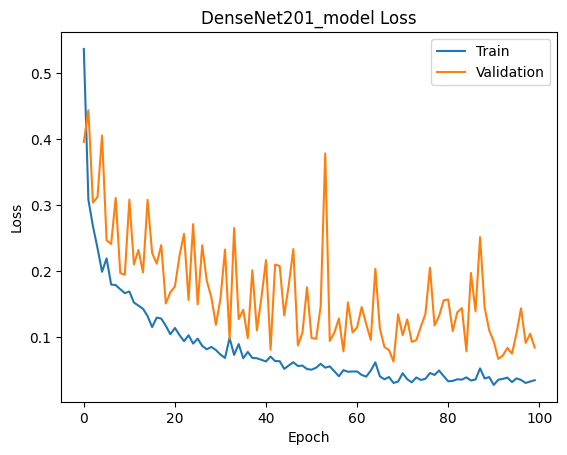

In [46]:
# Plot the training and validation loss over epochs
plt.plot(history_DenseNet201_model.history['loss'])
plt.plot(history_DenseNet201_model.history['val_loss'])
plt.title('DenseNet201_model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [47]:
# Evaluate the model
loss_DenseNet201_model, accuracy_DenseNet201_model = DenseNet201_model.evaluate(test_set, steps=test_set.samples // batch_size)
# loss, accuracy = model.evaluate(test_set, steps=32)

print("DenseNet201_model Test Loss:", loss_DenseNet201_model)
print("DenseNet201_model Test Accuracy:", accuracy_DenseNet201_model)

40/40 [==============================] - 6s 143ms/step - loss: 0.0845 - accuracy: 0.9711
DenseNet201_model Test Loss: 0.08451686799526215
DenseNet201_model Test Accuracy: 0.9710937738418579


41/41 [==============================] - 16s 325ms/step
[0 0 0 ... 3 3 3]


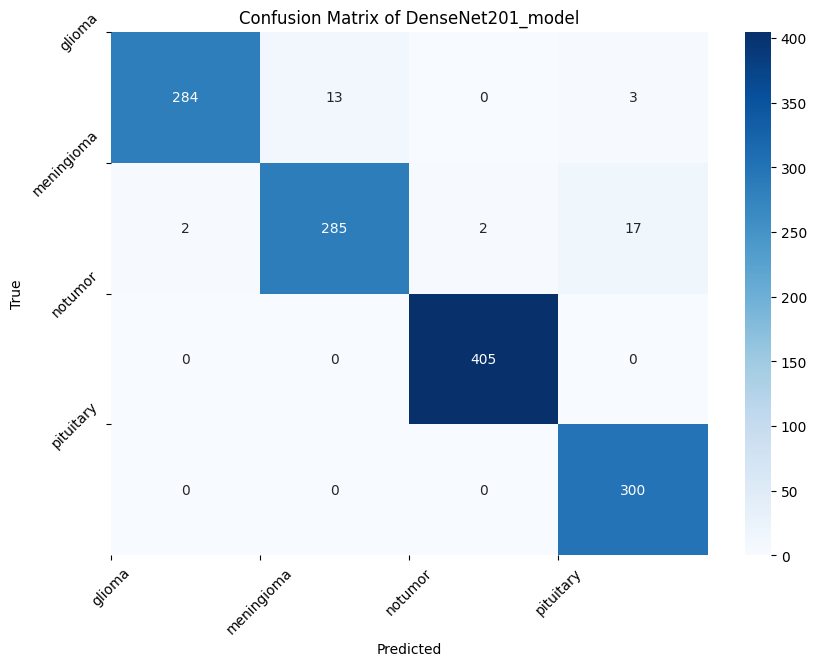

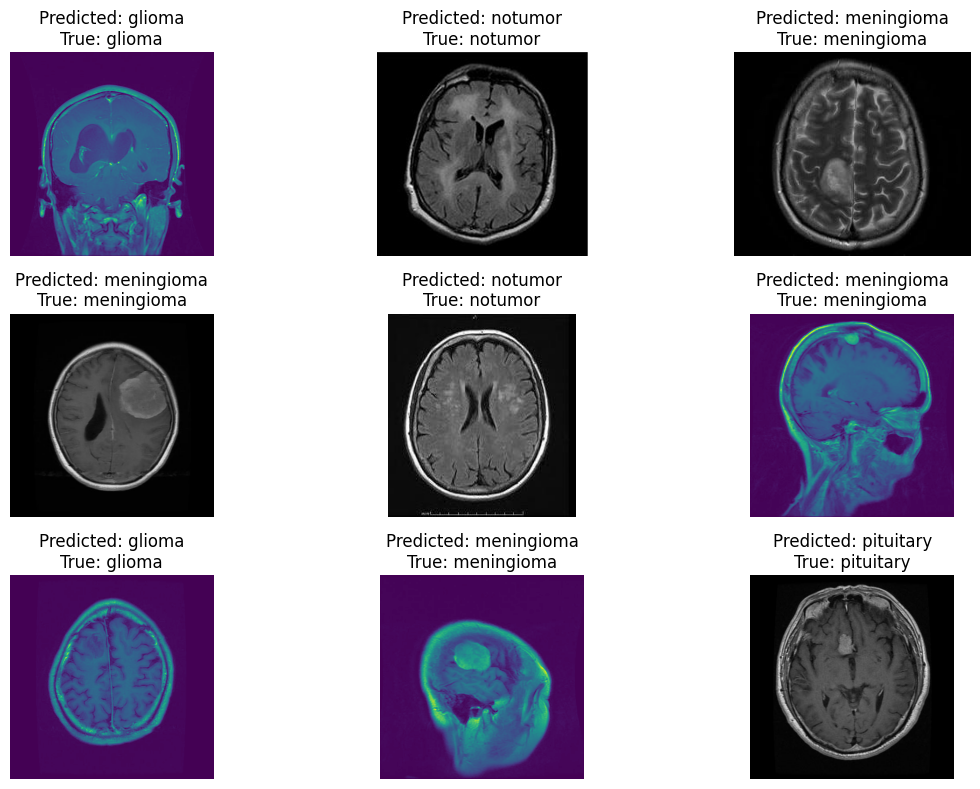

In [48]:
# Make predictions on the test dataset
predictions_DenseNet201_model = DenseNet201_model.predict(test_set)
predicted_categories_DenseNet201_model = np.argmax(predictions_DenseNet201_model, axis=1)

true_categories_DenseNet201_model = test_set.classes
print(true_categories_DenseNet201_model)

# Create a confusion matrix
confusion_matrix_DenseNet201_model = tf.math.confusion_matrix(true_categories_DenseNet201_model, predicted_categories_DenseNet201_model)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_DenseNet201_model, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of DenseNet201_model")
plt.tight_layout() #########
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_set.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
# print(sample_indices)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions_DenseNet201_model = [categories[predicted_categories_DenseNet201_model[i]] for i in sample_indices]
sample_true_labels_DenseNet201_model = [categories[true_categories_DenseNet201_model[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions_DenseNet201_model[i]}\nTrue: {sample_true_labels_DenseNet201_model[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Class: glioma
Precision: 0.993006993006993
Recall: 0.9466666666666667
F1-Score: 0.969283276450512

Class: meningioma
Precision: 0.9563758389261745
Recall: 0.9313725490196079
F1-Score: 0.9437086092715231

Class: notumor
Precision: 0.995085995085995
Recall: 1.0
F1-Score: 0.9975369458128079

Class: pituitary
Precision: 0.9375
Recall: 1.0
F1-Score: 0.967741935483871



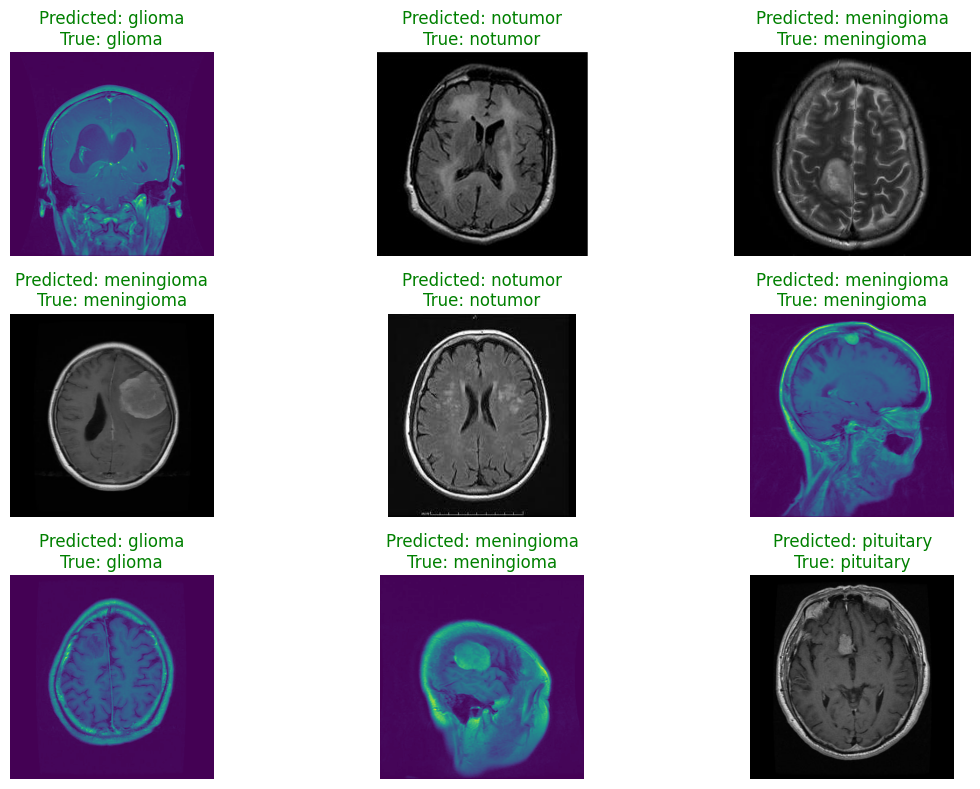

In [49]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision_DenseNet201_model = np.diag(confusion_matrix_DenseNet201_model) / np.sum(confusion_matrix_DenseNet201_model, axis=0)
recall_DenseNet201_model = np.diag(confusion_matrix_DenseNet201_model) / np.sum(confusion_matrix_DenseNet201_model, axis=1)
f1_score_DenseNet201_model = 2 * (precision_DenseNet201_model * recall_DenseNet201_model) / (precision_DenseNet201_model + recall_DenseNet201_model)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision_DenseNet201_model[i]}")
    print(f"Recall: {recall_DenseNet201_model[i]}")
    print(f"F1-Score: {f1_score_DenseNet201_model[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions_DenseNet201_model[i] == sample_true_labels_DenseNet201_model[i]:
        plt.title(f"Predicted: {sample_predictions_DenseNet201_model[i]}\nTrue: {sample_true_labels_DenseNet201_model[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions_DenseNet201_model[i]}\nTrue: {sample_true_labels_DenseNet201_model[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

4


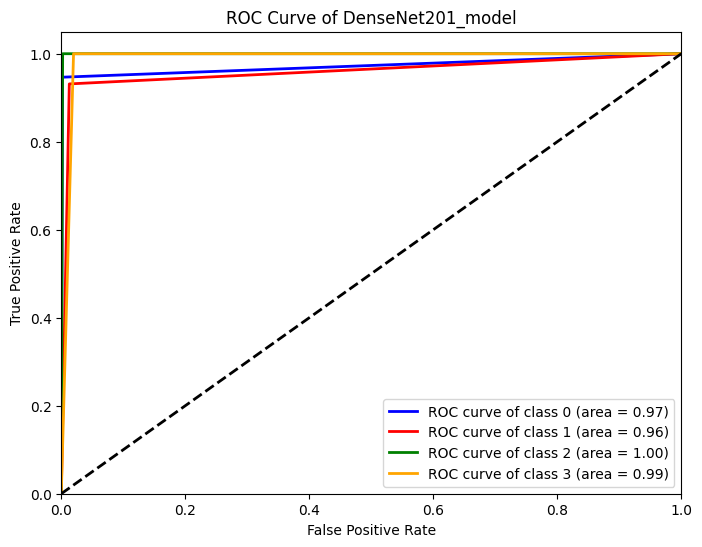

In [50]:
from sklearn.metrics import roc_curve, auc
from keras.models import load_model
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes = glob('/kaggle/input/brain-tumor-mri-dataset/Training/*')
num_classes = len(classes)
print(num_classes)

Y_test_bin = label_binarize(true_categories_DenseNet201_model, classes=np.arange(4))
Y_pred_bin = label_binarize(predicted_categories_DenseNet201_model, classes=np.arange(4))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']  # Add more colors if you have more classes

class_names = ["glioma", "meningioma", "notumor", "pituitary"]

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of DenseNet201_model')
plt.legend(loc="lower right")

plt.show()


In [51]:
# Save the trained model
DenseNet201_model.save("DenseNet201_model_brain_tumor_detection_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
from tensorflow.keras.models import load_model

xception_model = load_model('/kaggle/working/Xception_model_brain_tumor_detection_model.h5')
xception_model = Model(inputs=xception_model.inputs,
                       outputs=xception_model.outputs,
                       name='xception_model')

InceptionV3_model = load_model('/kaggle/working/InceptionV3_model_brain_tumor_detection_model.h5')
InceptionV3_model = Model(inputs=InceptionV3_model.inputs,
                       outputs=InceptionV3_model.outputs,
                       name='InceptionV3_model')

DenseNet201_model = load_model('/kaggle/working/DenseNet201_model_brain_tumor_detection_model.h5')
DenseNet201_model = Model(inputs=DenseNet201_model.inputs,
                       outputs=DenseNet201_model.outputs,
                       name='DenseNet201_model')

models = [xception_model, InceptionV3_model, DenseNet201_model]

In [70]:
model_input = Input(shape = (224, 224, 3))
model_outputs = [model(model_input) for model in models]


class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w1, w2, w3, **Kwargs):
        super(WeightedAverageLayer, self).__init__(**Kwargs)
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        
    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1] + self.w3 * inputs[2] 


Ensamble_output = WeightedAverageLayer(0.2, 0.3, 0.5)(model_outputs)
Ensamble_model = Model(inputs=model_input, outputs=Ensamble_output, name='Ensamble_model')

In [71]:
# adam = keras.optimizers.Adam(learning_rate=0.0001) 
Ensamble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history_Ensamble_model = Ensamble_model.fit(
    train_set,
    steps_per_epoch=train_set.samples // batch_size,
    epochs = 20,
    validation_data=test_set,
    validation_steps=test_set.samples // batch_size
)

Epoch 1/20
178/178 [==============================] - 174s 770ms/step - loss: 0.0327 - accuracy: 0.9954 - val_loss: 0.0606 - val_accuracy: 0.9844
Epoch 2/20
178/178 [==============================] - 132s 739ms/step - loss: 0.0284 - accuracy: 0.9949 - val_loss: 0.0782 - val_accuracy: 0.9742
Epoch 3/20
178/178 [==============================] - 132s 738ms/step - loss: 0.0259 - accuracy: 0.9963 - val_loss: 0.0796 - val_accuracy: 0.9766
Epoch 4/20
178/178 [==============================] - 132s 739ms/step - loss: 0.0368 - accuracy: 0.9944 - val_loss: 0.0860 - val_accuracy: 0.9727
Epoch 5/20
178/178 [==============================] - 132s 738ms/step - loss: 0.0328 - accuracy: 0.9942 - val_loss: 0.0772 - val_accuracy: 0.9758
Epoch 6/20
178/178 [==============================] - 132s 739ms/step - loss: 0.0215 - accuracy: 0.9979 - val_loss: 0.0688 - val_accuracy: 0.9766
Epoch 7/20
178/178 [==============================] - 132s 740ms/step - loss: 0.0216 - accuracy: 0.9977 - val_loss: 0.0453 -

In [1]:
# Plot the training and validation accuracy over epochs
plt.plot(history_Ensamble_model.history['accuracy'])
plt.plot(history_Ensamble_model.history['val_accuracy'])
plt.title('Ensamble_model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# axes = plt.axes()
# axes.set_ylim([0.9, 1])
plt.legend(['Train', 'Validation'])
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Plot the training and validation loss over epochs
plt.plot(history_Ensamble_model.history['loss'])
plt.plot(history_Ensamble_model.history['val_loss'])
plt.title('Ensamble_model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
# Evaluate the model
loss_Ensamble_model, accuracy_Ensamble_model = Ensamble_model.evaluate(test_set, steps=test_set.samples // batch_size)
# loss, accuracy = model.evaluate(test_set, steps=32)

print("Ensamble_model Test Loss:", loss_Ensamble_model)
print("Ensamble_model Test Accuracy:", accuracy_Ensamble_model)

41/41 [==============================] - 18s 324ms/step
[0 0 0 ... 3 3 3]


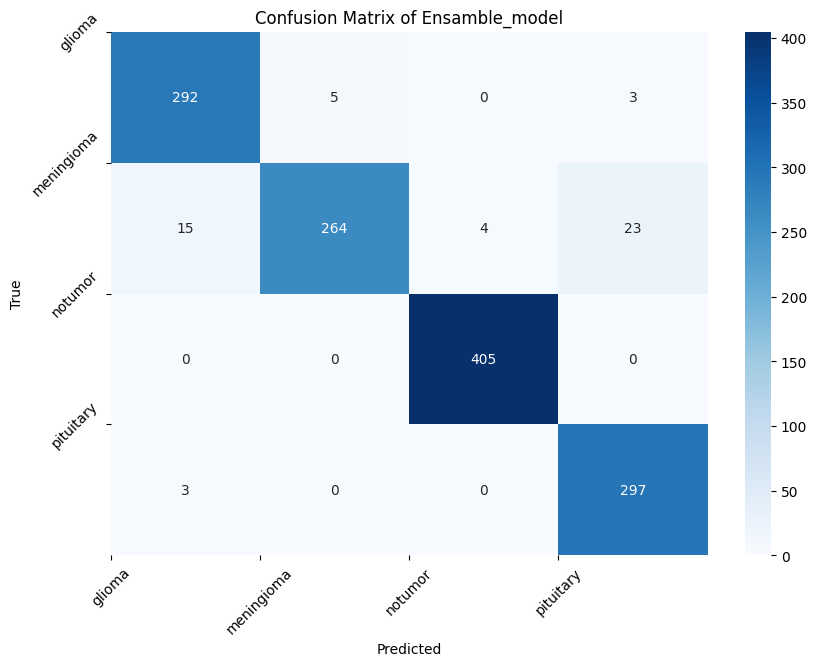

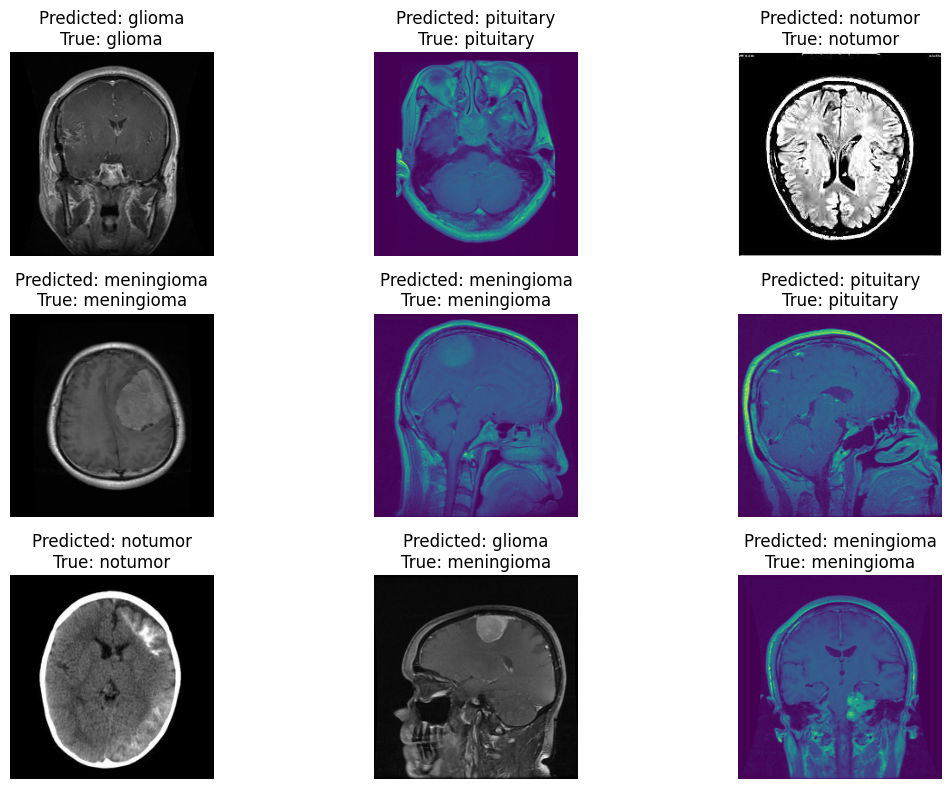

In [62]:
# Make predictions on the test dataset
predictions_Ensamble_model = Ensamble_model.predict(test_set)
predicted_categories_Ensamble_model = np.argmax(predictions_Ensamble_model, axis=1)

true_categories_Ensamble_model = test_set.classes
print(true_categories_Ensamble_model)

# Create a confusion matrix
confusion_matrix_Ensamble_model = tf.math.confusion_matrix(true_categories_Ensamble_model, predicted_categories_Ensamble_model)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_Ensamble_model, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of Ensamble_model")
plt.tight_layout() #########
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_set.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
# print(sample_indices)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions_Ensamble_model = [categories[predicted_categories_Ensamble_model[i]] for i in sample_indices]
sample_true_labels_Ensamble_model = [categories[true_categories_Ensamble_model[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions_Ensamble_model[i]}\nTrue: {sample_true_labels_Ensamble_model[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Class: glioma
Precision: 0.9419354838709677
Recall: 0.9733333333333334
F1-Score: 0.9573770491803278

Class: meningioma
Precision: 0.9814126394052045
Recall: 0.8627450980392157
F1-Score: 0.9182608695652174

Class: notumor
Precision: 0.9902200488997555
Recall: 1.0
F1-Score: 0.995085995085995

Class: pituitary
Precision: 0.9195046439628483
Recall: 0.99
F1-Score: 0.9534510433386837



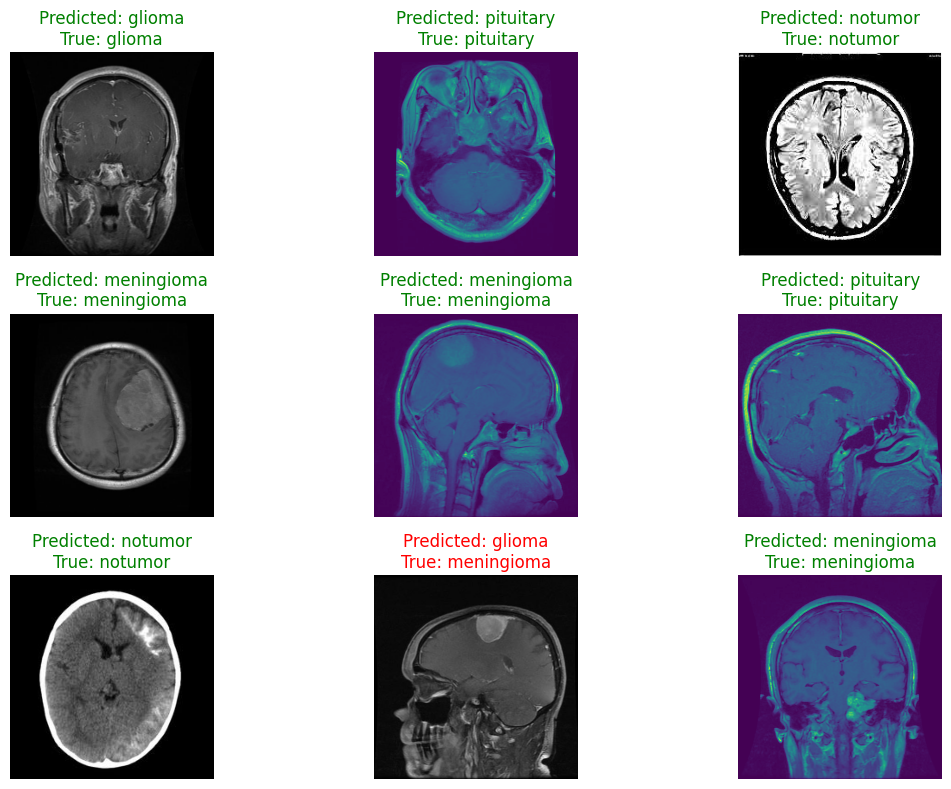

In [63]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision_Ensamble_model = np.diag(confusion_matrix_Ensamble_model) / np.sum(confusion_matrix_Ensamble_model, axis=0)
recall_Ensamble_model = np.diag(confusion_matrix_Ensamble_model) / np.sum(confusion_matrix_Ensamble_model, axis=1)
f1_score_Ensamble_model = 2 * (precision_Ensamble_model * recall_Ensamble_model) / (precision_Ensamble_model + recall_Ensamble_model)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision_Ensamble_model[i]}")
    print(f"Recall: {recall_Ensamble_model[i]}")
    print(f"F1-Score: {f1_score_Ensamble_model[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions_Ensamble_model[i] == sample_true_labels_Ensamble_model[i]:
        plt.title(f"Predicted: {sample_predictions_Ensamble_model[i]}\nTrue: {sample_true_labels_Ensamble_model[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions_Ensamble_model[i]}\nTrue: {sample_true_labels_Ensamble_model[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

4


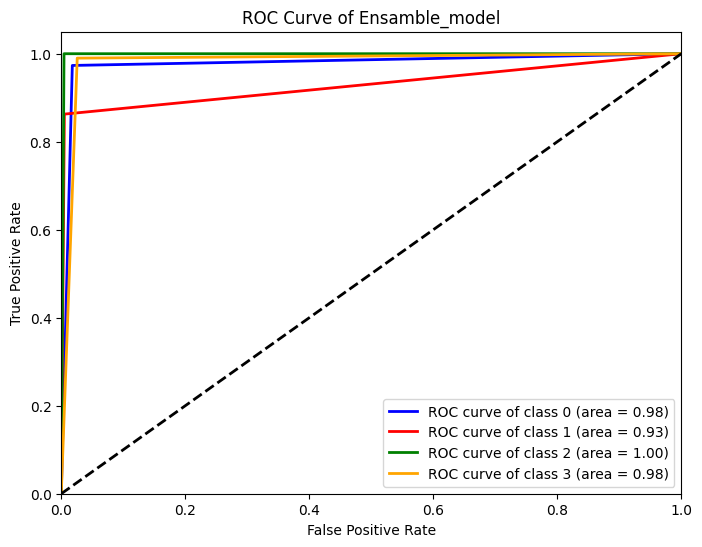

In [64]:
from sklearn.metrics import roc_curve, auc
from keras.models import load_model

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes = glob('/kaggle/input/brain-tumor-mri-dataset/Training/*')
num_classes = len(classes)
print(num_classes)

Y_test_bin = label_binarize(true_categories_Ensamble_model, classes=np.arange(4))
Y_pred_bin = label_binarize(predicted_categories_Ensamble_model, classes=np.arange(4))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']  # Add more colors if you have more classes

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Ensamble_model')
plt.legend(loc="lower right")

plt.show()

In [65]:
# Save the trained model
Ensamble_model.save("EL_model_brain_tumor_detection_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
